## Sample Dogs vs Cats

Kaggle Dogs vs Cat sample

- dataset: https://www.kaggle.com/c/dogs-vs-cats
- reference source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- similar implementation using caffe: http://adilmoujahid.com/posts/2016/06/introduction-deep-learning-python-caffe/

This sample demonstrates:

- various CNN models
- improve learning by transfer learning and hyperparameters
- checkpoint

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD
from keras import backend as K
import keras

import datetime, sys, getopt
import matplotlib.pyplot as plt

from cnnmodel import simpleCNN, vgg9CNN, vgg16CNN, vgg16CNNtl, resnet50tl

print(keras.__version__)

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.1.4


__Note__: download dataset and organize into following dir structure

```
- train
       - cats
       - dogs
- test
       - cats
       - dogs       
```

In [2]:
# test resnet50tl
model_opt = "resnet50tl"
act_opt = "sigmoid" # binary classification use 'sigmoid', categorical use 'softmax'
lr, decay, momentum, nesterov = 1e-05, 0.0, 0.0, False

K.clear_session() # Clear previous models from memory.

img_width, img_height = 200, 200 # for resnet50, min size = 197x197

In [3]:
train_data_dir = '../datasets/catsdogs/train'
validation_data_dir = '../datasets/catsdogs/test'
epochs = 10
batch_size = 16
numclasses = 1
  
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

nb_train_samples = 2000 # get this size from output of flow_from_directory
nb_validation_samples = 800
print(train_generator.class_indices)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


In [4]:
# input shape
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
# optimizer
#_optimizer = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=nesterov)
_optimizer = RMSprop(lr=lr, decay=decay)

# model
if (model_opt == "simple"):
     model = simpleCNN(input_shape, numclasses, act_opt)
elif (model_opt == "vgg9"):
     model = vgg9CNN(input_shape, numclasses, act_opt)
elif (model_opt == "vgg16"):
        model = vgg16CNN(input_shape, numclasses, act_opt)
elif (model_opt == "vgg16tl"):
        model = vgg16CNNtl(input_shape, numclasses, act_opt)
elif (model_opt == "resnet50tl"):
        model = resnet50tl(input_shape, numclasses, act_opt)
else: #if (model_opt == "vgg9"):
    model = vgg9CNN(input_shape, numclasses, act_opt)

model.compile(loss='binary_crossentropy', optimizer=_optimizer, metrics=['accuracy'])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100, 100, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [5]:
epochs = 10
weigth_file = "../models/dogscats_%s_weight.h5" % model_opt

In [6]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
125/125 [==============================] - 90s 721ms/step - loss: 0.3530 - acc: 0.8490 - val_loss: 0.0767 - val_acc: 0.9750
Epoch 2/10
125/125 [==============================] - 72s 578ms/step - loss: 0.1036 - acc: 0.9690 - val_loss: 0.0617 - val_acc: 0.9800
Epoch 3/10
125/125 [==============================] - 73s 581ms/step - loss: 0.0732 - acc: 0.9760 - val_loss: 0.0619 - val_acc: 0.9750
Epoch 4/10
125/125 [==============================] - 73s 582ms/step - loss: 0.0556 - acc: 0.9790 - val_loss: 0.0521 - val_acc: 0.9800
Epoch 5/10
125/125 [==============================] - 73s 587ms/step - loss: 0.0369 - acc: 0.9860 - val_loss: 0.0667 - val_acc: 0.9812
Epoch 6/10
125/125 [==============================] - 74s 591ms/step - loss: 0.0362 - acc: 0.9870 - val_loss: 0.0626 - val_acc: 0.9825
Epoch 7/10
125/125 [==============================] - 74s 591ms/step - loss: 0.0200 - acc: 0.9950 - val_loss: 0.0641 - val_acc: 0.9812
Epoch 8/10
125/125 [==============================] - 7

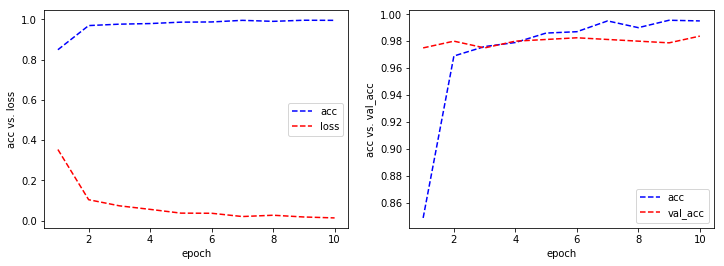

In [7]:
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(loss) + 1)

# Visualize loss history
fig=plt.figure(figsize=(12, 4))
plt.figure(1)

fig.add_subplot(121)
plt.plot(epoch_count, acc, 'b--')
plt.plot(epoch_count, loss, 'r--')
plt.legend(['acc', 'loss'])
plt.xlabel('epoch')
plt.ylabel('acc vs. loss')

fig.add_subplot(122)
plt.plot(epoch_count, acc, 'b--')
plt.plot(epoch_count, val_acc, 'r--')
plt.legend(['acc', 'val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc vs. val_acc')

plt.show();

### Predict

In [8]:
import requests
from PIL import Image
import cv2
from keras.preprocessing import image
import numpy as np
from io import BytesIO

In [9]:
label = ["cats", "dogs"]

0, cats, 0.00%


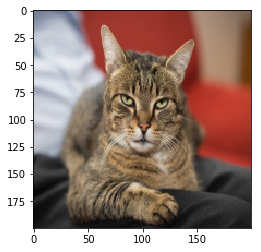

In [10]:
#test_url = "https://i.ytimg.com/vi/SfLV8hD7zX4/maxresdefault.jpg" # dog
test_url = "https://boygeniusreport.files.wordpress.com/2017/01/cat.jpg" # cat

r = requests.get(test_url)

img = Image.open(BytesIO(r.content))
rsimg = cv2.resize(np.array(img), (img_width, img_height), interpolation = cv2.INTER_AREA)
plt.imshow(rsimg)

img = Image.fromarray(rsimg)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.
out = np.squeeze( model.predict(x) )

pred = 1 if (out >= 0.5) else 0
print("{}, {}, {:.2f}%".format(pred, label[pred], out*100))

### Experiment

run script [dogscats.py](./dogscats.py) to evaluate performances of learning

In [11]:
import sys
import numpy
import pandas
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# lr = 0.00001, rmsprop, resnet50tl
csvpath='../output/resnet50tl-rmsprop-0.001-180706-49.300000.txt'
dataset = pandas.read_csv(csvpath)

In [13]:
print(dataset.head(10))

     loss     acc   val_loss   val_acc
0  8.0159  0.5005     8.0590     0.500
1  3.6552  0.5070     8.0590     0.500
2  1.2832  0.5025     7.9712     0.500
3  1.2392  0.5270     7.8405     0.500
4  1.2552  0.4930     4.3605     0.545


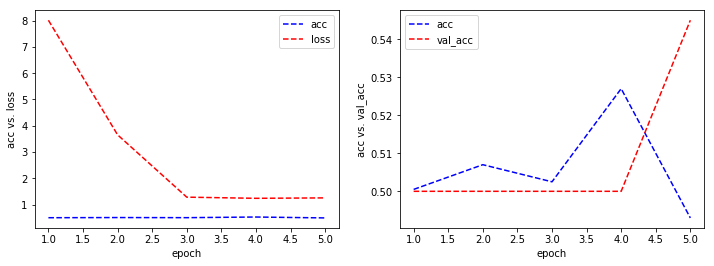

In [14]:
# get columns
d = dataset.values

loss = d[:, 0]
acc = d[:, 1]
val_loss = d[:, 2]
val_acc = d[:, 3]

# Create count of the number of epochs
epoch_count = range(1, len(d)+1)

# Visualize loss history
fig=plt.figure(figsize=(12, 4))
plt.figure(1)

fig.add_subplot(121)
plt.plot(epoch_count, acc, 'b--')
plt.plot(epoch_count, loss, 'r--')
plt.legend(['acc', 'loss'])
plt.xlabel('epoch')
plt.ylabel('acc vs. loss')

fig.add_subplot(122)
plt.plot(epoch_count, acc, 'b--')
plt.plot(epoch_count, val_acc, 'r--')
plt.legend(['acc', 'val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc vs. val_acc')

plt.show()